# 第三章 训练一个扩散模型

在本notebook中，我们将使用 W&B 来训练扩散模型。 我们将使用[扩散模型如何工作](https://www.deeplearning.ai/short-courses/how-diffusion-models-work/)”课程中的 Lab3 笔记本。 我们将添加：

* 记录训练损失和指标
* 在训练期间从模型中采样并将样本上传到 W&B
* 将模型保存到 W&B

In [5]:

from types import SimpleNamespace #是一种简单的命名空间来存储和访问数据的库
from pathlib import Path
from tqdm.notebook import tqdm
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
from utilities import * #实现DDPM、DDIM的一些库

import wandb

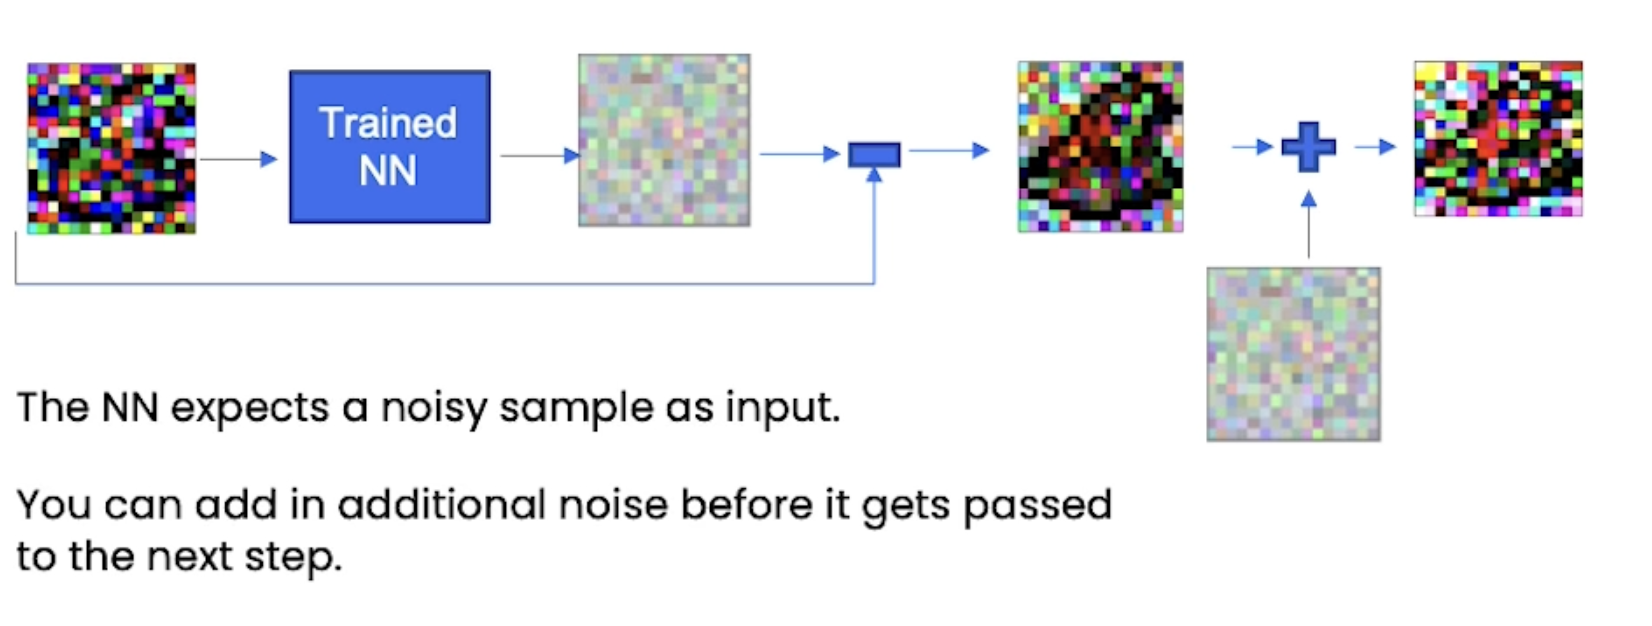

假设你想做一个以文生图的模型，你的目的是给一段文字，再随便给一张图（比如一张噪声），这个模型能帮你产出符合文字描述的逼真图片。在这个目的实现的过程中，首先需要模型为你生成一张逼真的图片，然后模型基于你的文字描述进行修正，进一步生成你想要的图。在此过程中，DDPM(Denoising Diffusion Probalistic Models)的作用就是学习训练数据的分布，尽可能生产符合数据分布的真实图片。

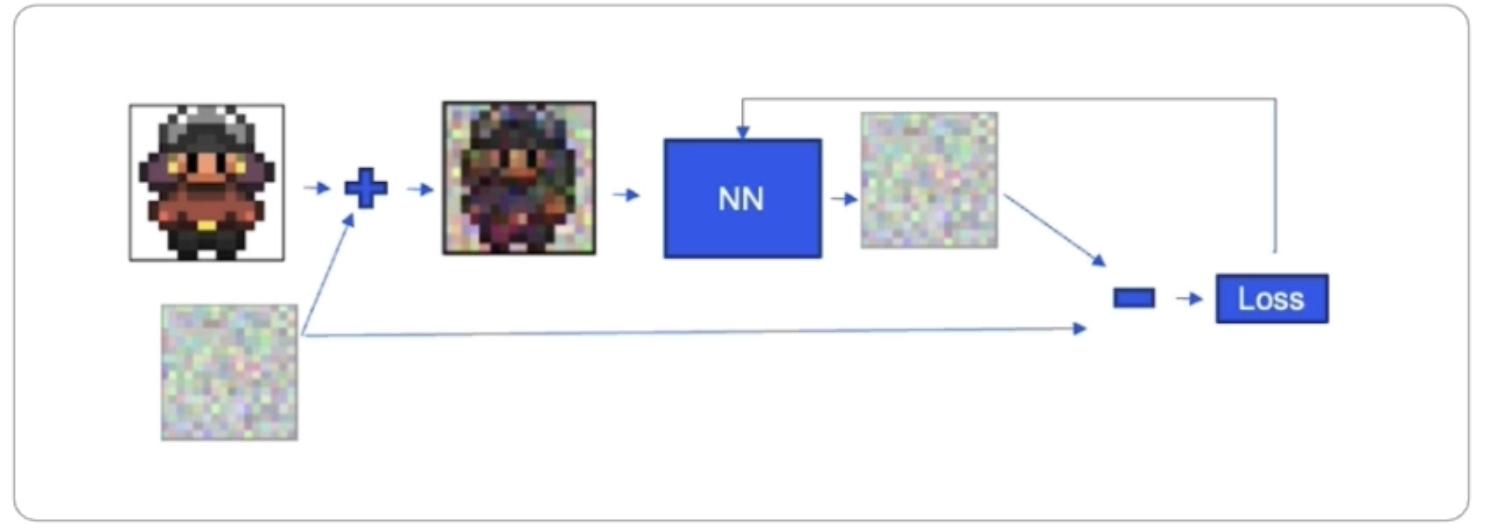
神经网络学习预测噪声——真正学习非噪声的分布
对每个图像进行随机时间步长（噪声级别）采样，以更稳定地训练。每一个time_step中都sample一次随机噪声，最终每一次添加的噪声都是一个标准高斯分布。

In [6]:
#登录wb网站
wandb.login(anonymous="allow")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: xiaopan. Use `wandb login --relogin` to force relogin


True

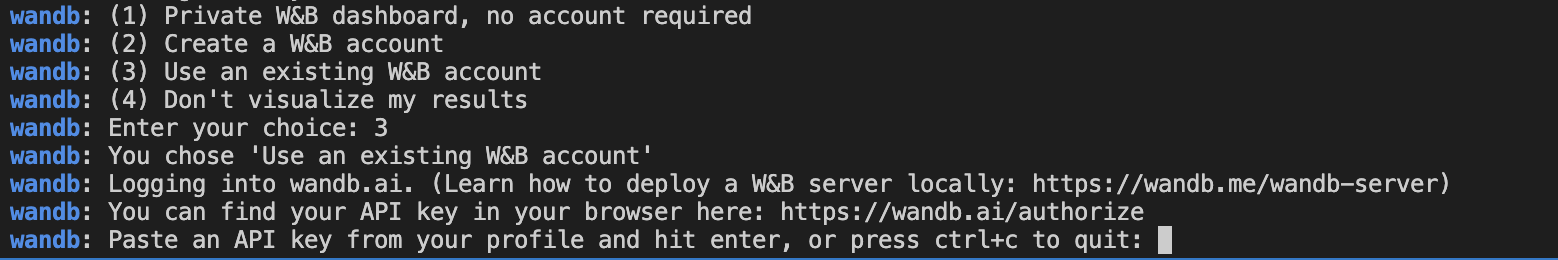
使用wb的账户的api key就可以链接到wb官网

In [7]:
# 我们正在将要记录的参数存储到 wandb
DATA_DIR = Path('./data/')
SAVE_DIR = Path('./data/weights/')
SAVE_DIR.mkdir(exist_ok=True, parents=True)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

config = SimpleNamespace(
    # 超参数设置
    num_samples = 30,

    # 扩散模型超参数 
    timesteps = 500,#采样的步长，步长越大，采样时间越长，步长和图片质量没有直接联系
    beta1 = 1e-4,#采样因子
    beta2 = 0.02,#采样因子

    # 网络超参数 
    n_feat = 64, # 64个隐藏层特征
    n_cfeat = 5, # 上下文向量的大小为 5
    height = 16, # 16x16 image
    
    # 训练超参数
    batch_size = 100,
    n_epoch = 32,
    lrate = 1e-3,
)

设置 DDPM 噪声调度器和采样器（与扩散课程中的相同）。
* perturb_input：在时间表上相应的时间步长向输入图像添加噪声
* Sample_ddpm_context：使用 DDPM 采样器生成图像，我们将在训练期间使用此函数定期从模型中采样并查看训练进展情况

In [8]:
# 设置 ddpm 采样器功能，通过不同的时间步添加标准高斯分布噪声
perturb_input, sample_ddpm_context = setup_ddpm(config.beta1, #采样因子
                                                config.beta2, #采样因子
                                                config.timesteps, #时间步
                                                DEVICE)

In [ ]:
'''
DDPM UNet是一个典型的Encoder-Decoder结构，在Encoder中，我们压缩图片大小，
逐步提取图片特征；在Decoder中，我们逐步还原图片大小。
由于压缩图片可能会损失掉信息，因此在decoder做还原时，我们会拼接Encoder层对应的特征图（skip connection），
尽量减少信息损失
'''
# 构建模型 unet构建，去噪过程，这一步中我们训练一个UNet架构的去噪模型
nn_model = ContextUnet(in_channels=3, #输入通道数
                       n_feat=config.n_feat, #中间特征图数
                       n_cfeat=config.n_cfeat, #类别数
                       height=config.height).to(DEVICE)

In [10]:
# 加载数据集和定义的超参数
dataset = CustomDataset.from_np(path=DATA_DIR)
dataloader = DataLoader(dataset, 
                        batch_size=config.batch_size, 
                        shuffle=True)
optim = torch.optim.Adam(nn_model.parameters(), lr=config.lrate)

我们选择一个固定的上下文向量，每个类别有 6 个样本来指导我们的扩散，加噪过程就是通过给一张图片执行多个时间步进行添加高斯噪声

In [11]:
# Noise向量
# x_T ~ N(0, 1), 样本初始噪声
noises = torch.randn(config.num_samples, 3, 
                     config.height, config.height).to(DEVICE)  

# 用于采样的固定上下文向量，不同的样本进行扩散
ctx_vector = F.one_hot(torch.tensor([0,0,0,0,0,0,   # hero
                                     1,1,1,1,1,1,   # non-hero
                                     2,2,2,2,2,2,   # food
                                     3,3,3,3,3,3,   # spell
                                     4,4,4,4,4,4]), # side-facing 
                       5).to(DEVICE).float()

In [ ]:
# 初始化一个wandb
run = wandb.init(project="dlai_sprite_diffusion", 
                 job_type="train", 
                 config=config)

# 上传相关信息到wb
config = wandb.config

for ep in tqdm(range(config.n_epoch), leave=True, total=config.n_epoch):
    # 选择train模式
    nn_model.train()
    optim.param_groups[0]['lr'] = config.lrate*(1-ep/config.n_epoch)
    
    pbar = tqdm(dataloader, leave=False)
    for x, c in pbar:   # x: 图片  c: 上下文
        optim.zero_grad()
        x = x.to(DEVICE)
        c = c.to(DEVICE)   
        context_mask = torch.bernoulli(torch.zeros(c.shape[0]) + 0.8).to(DEVICE)#创建mask矩阵
        c = c * context_mask.unsqueeze(-1)        
        noise = torch.randn_like(x)#随机噪声样本
        t = torch.randint(1, config.timesteps + 1, (x.shape[0],)).to(DEVICE) #初始化时间步
        x_pert = perturb_input(x, t, noise) #按照时间步添加噪声     
        pred_noise = nn_model(x_pert, t / config.timesteps, c=c)   #生成扩散结果
        loss = F.mse_loss(pred_noise, noise)
        loss.backward()    
        optim.step()

        wandb.log({"loss": loss.item(),
                   "lr": optim.param_groups[0]['lr'],
                   "epoch": ep})


    # 定时保存训练的模型
    if ep%4==0 or ep == int(config.n_epoch-1):
        nn_model.eval()
        ckpt_file = SAVE_DIR/f"context_model.pth"
        torch.save(nn_model.state_dict(), ckpt_file)

        artifact_name = f"{wandb.run.id}_context_model"
        at = wandb.Artifact(artifact_name, type="model")
        at.add_file(ckpt_file)
        wandb.log_artifact(at, aliases=[f"epoch_{ep}"])

        samples, _ = sample_ddpm_context(nn_model, 
                                         noises, 
                                         ctx_vector[:config.num_samples])
        wandb.log({
            "train_samples": [
                wandb.Image(img) for img in samples.split(1)
            ]})
        
# finish W&B run
wandb.finish()

wandb: Network error (ConnectionError), entering retry loop.


最终通过wb可以看到DDPM是如何通过不同的时间步进行采样，最终生产一张逼真的照片

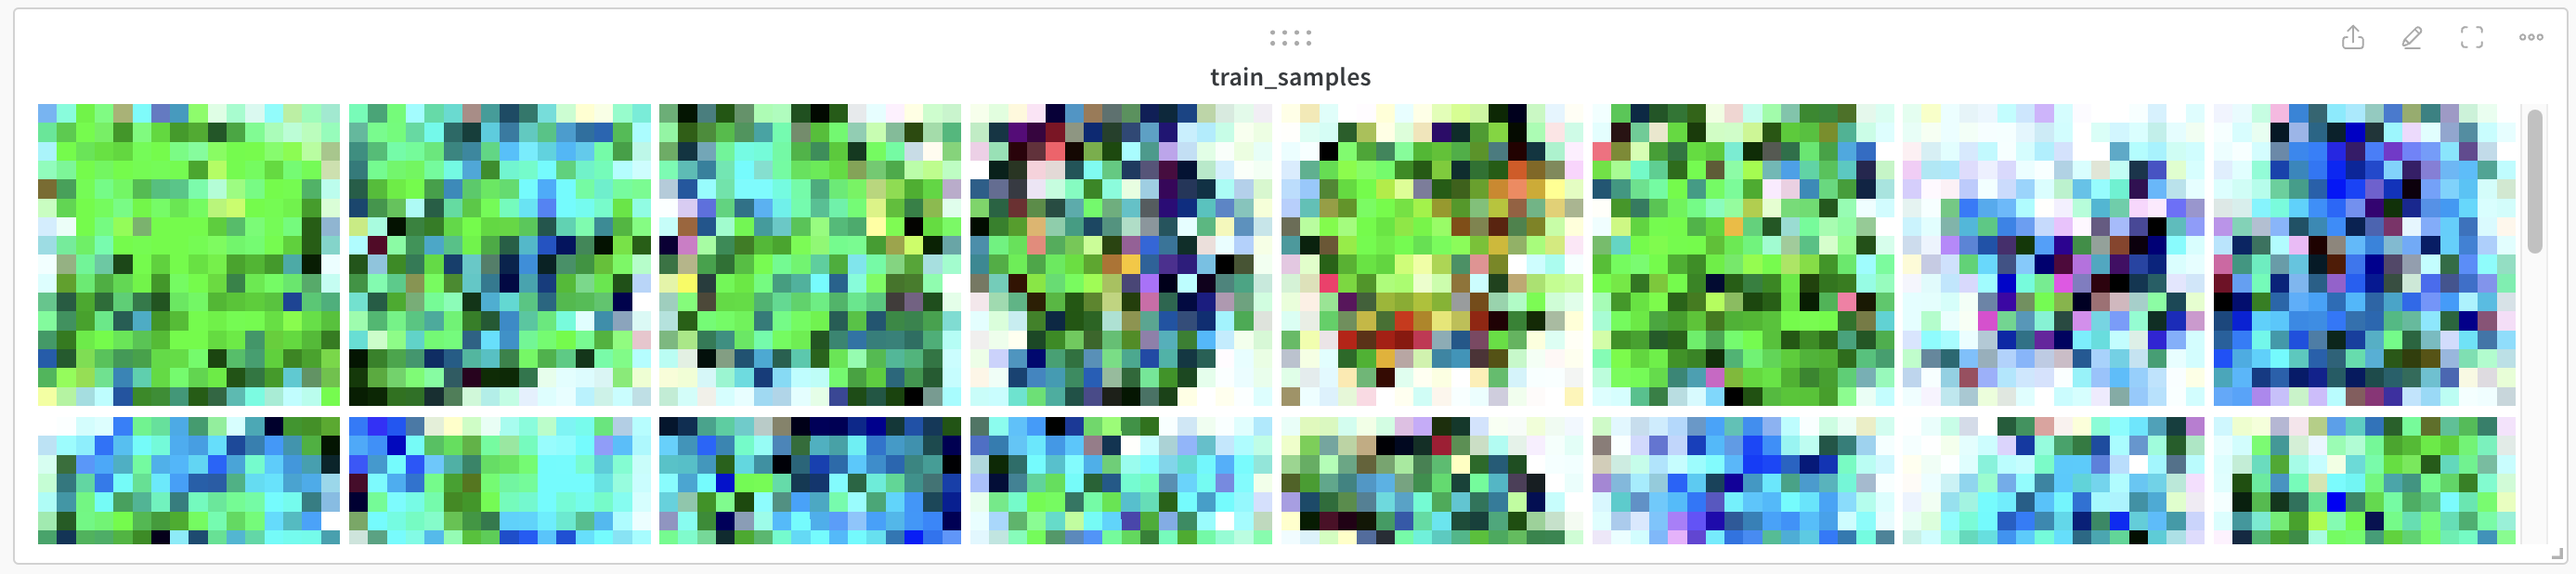
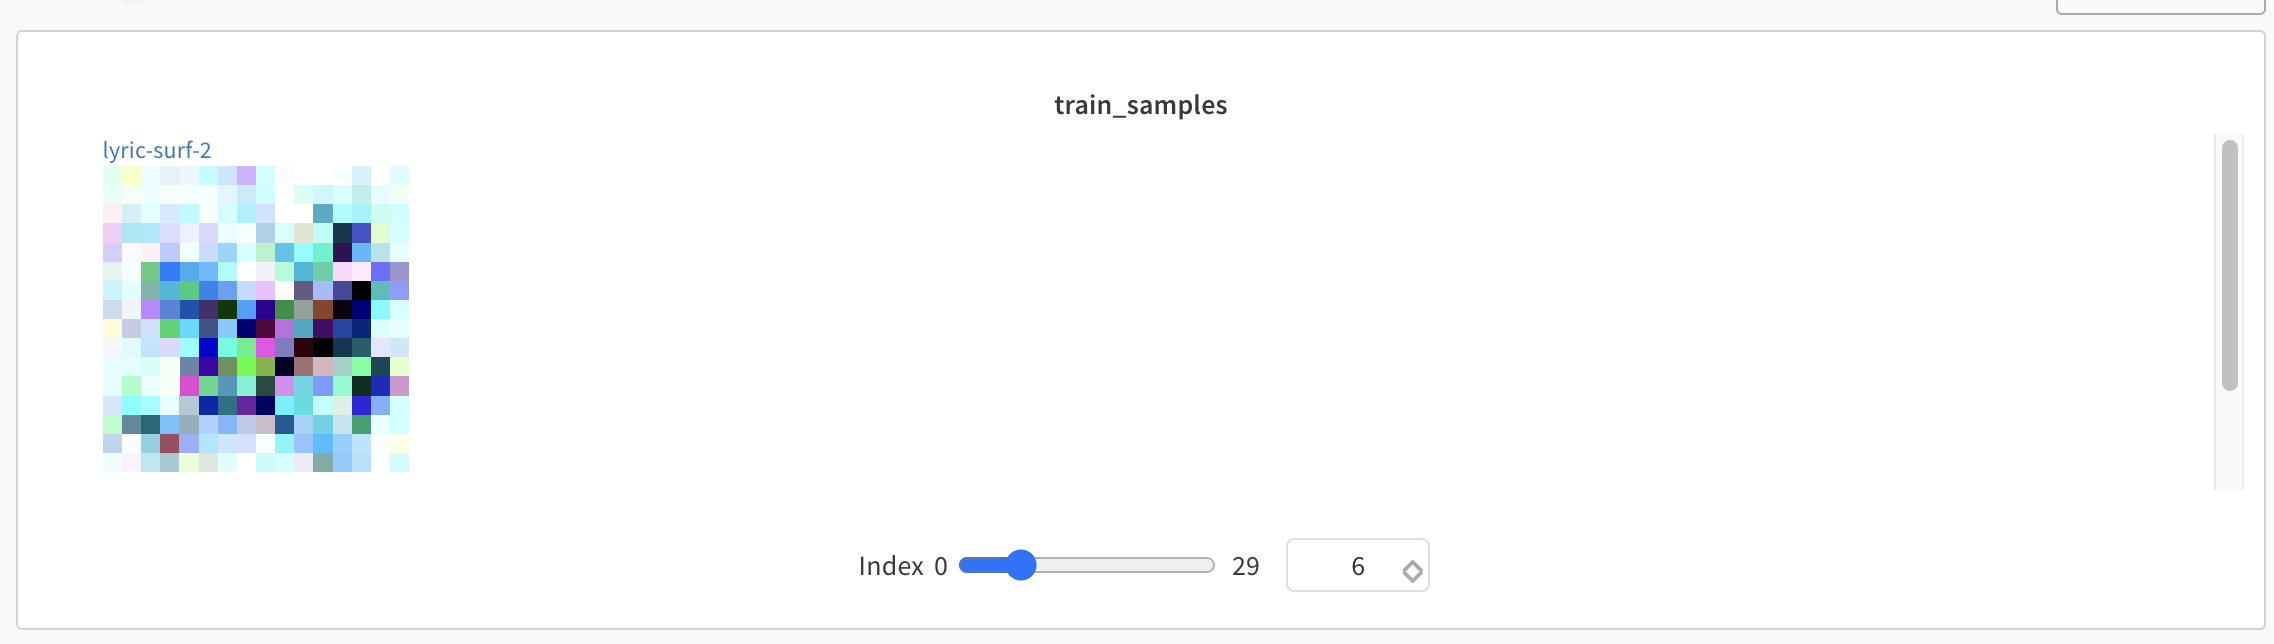
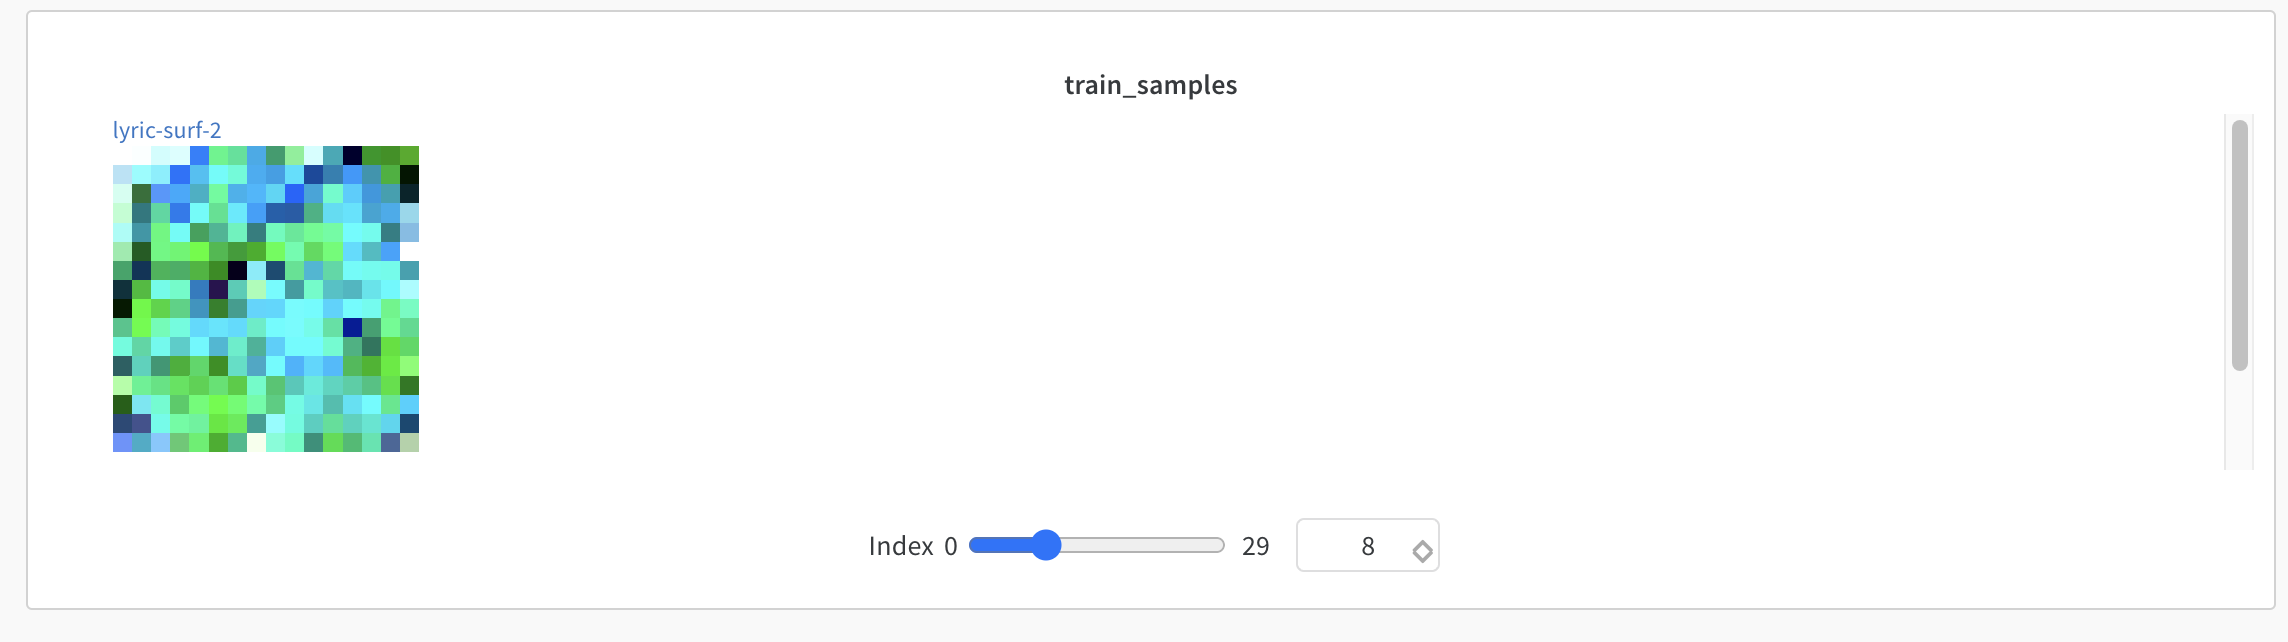
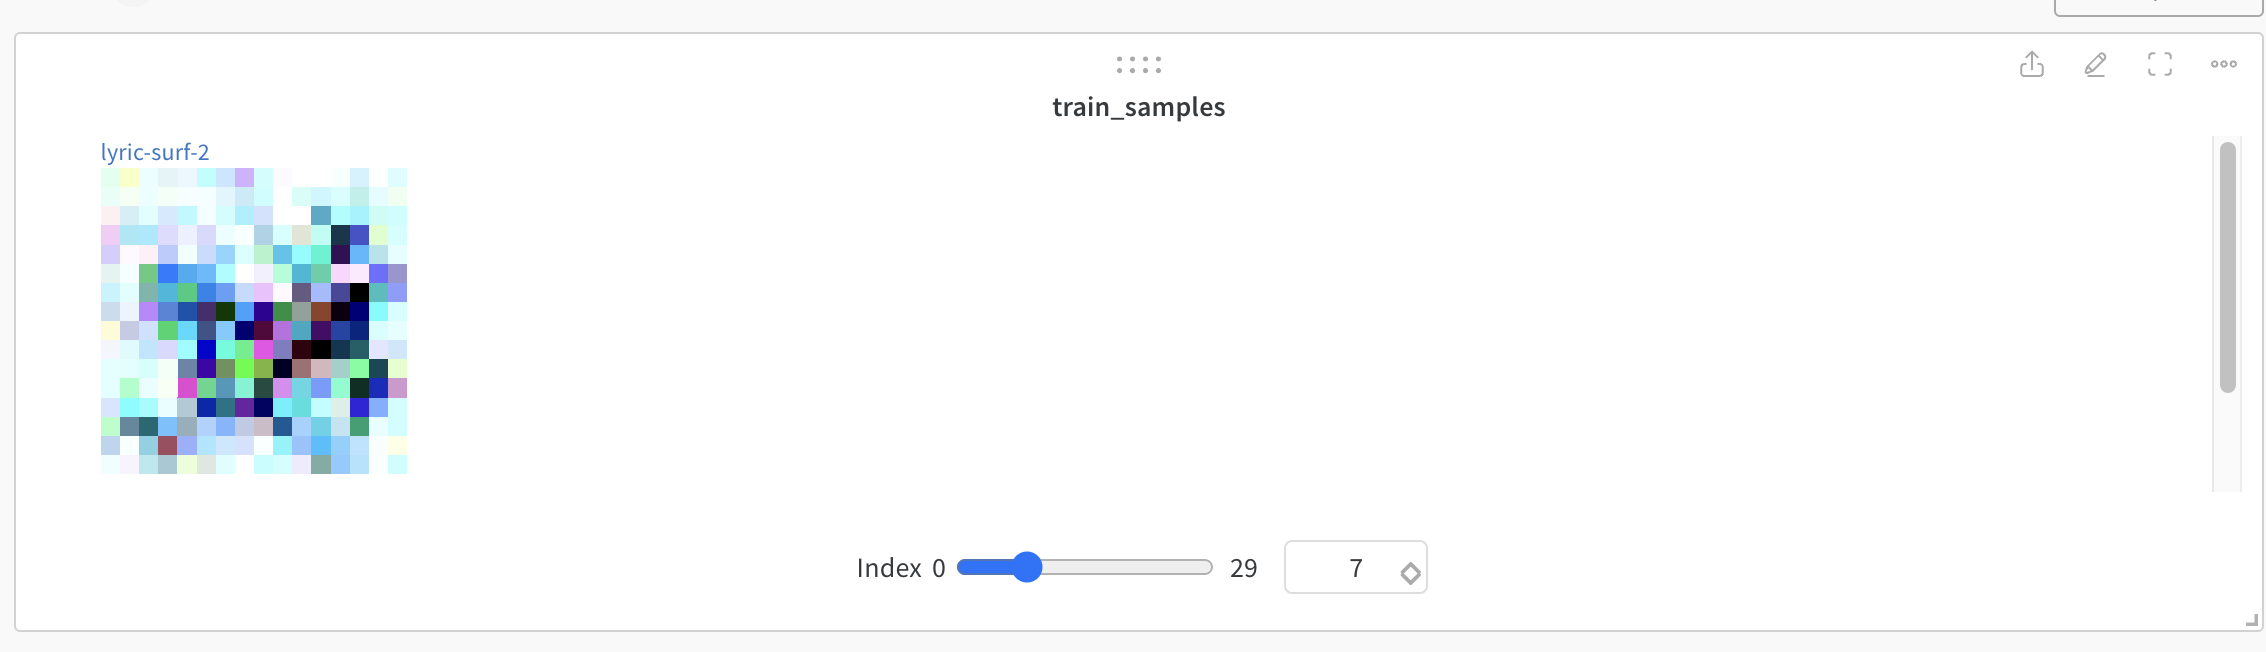
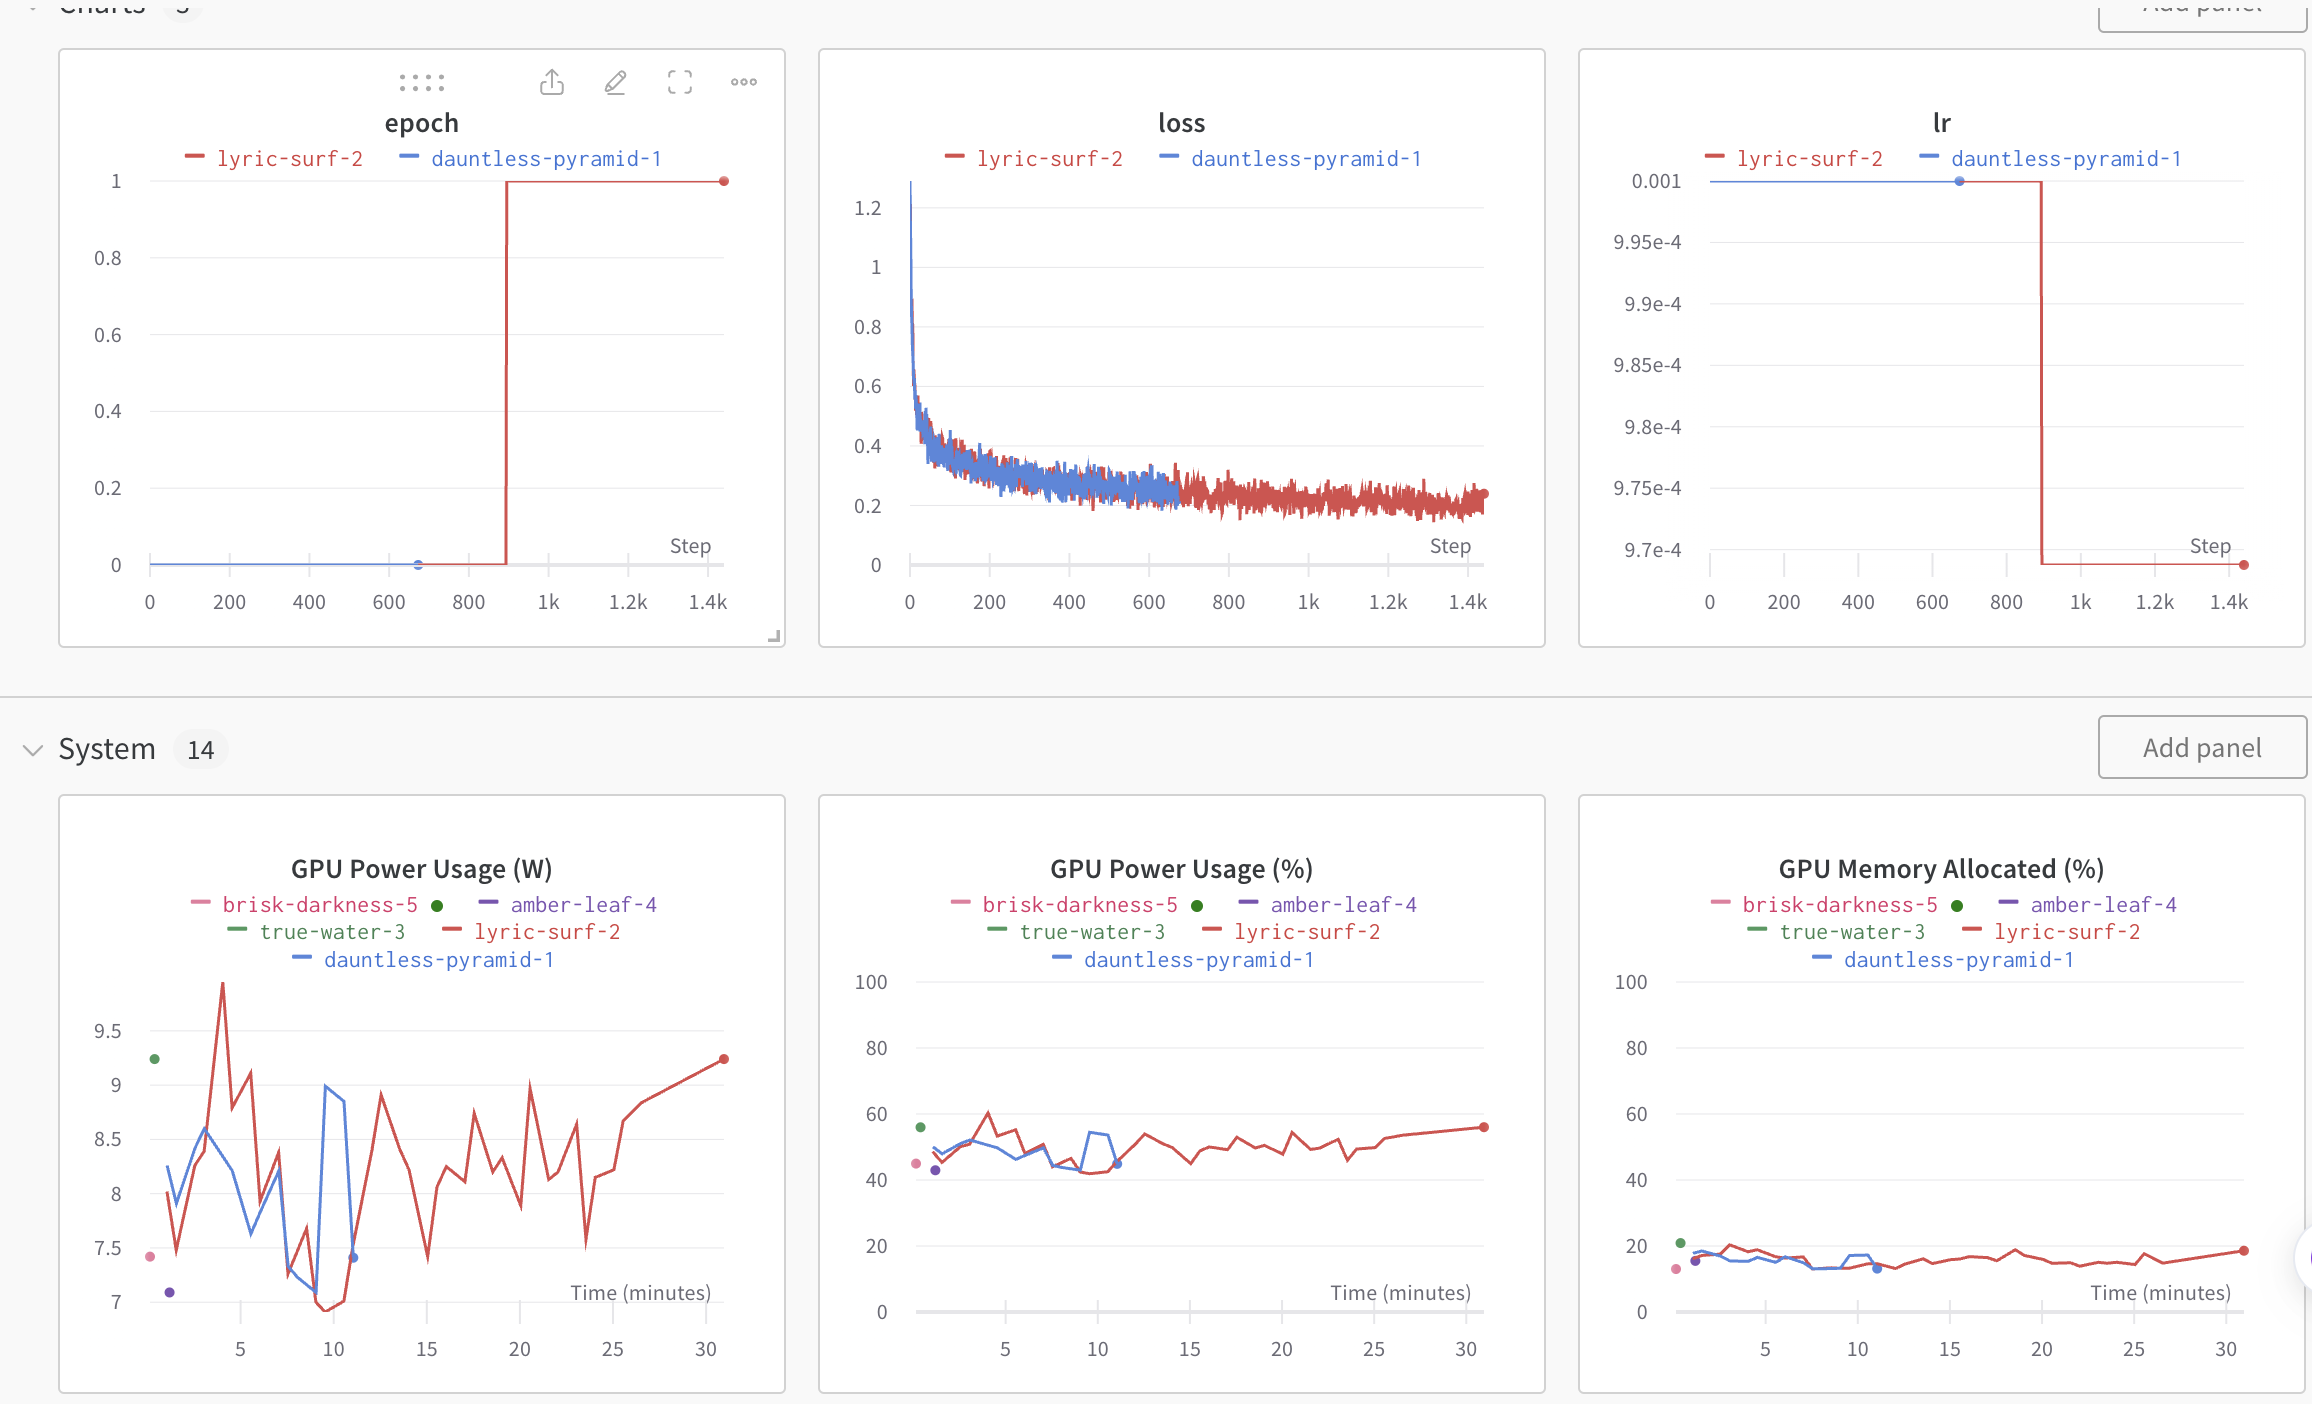
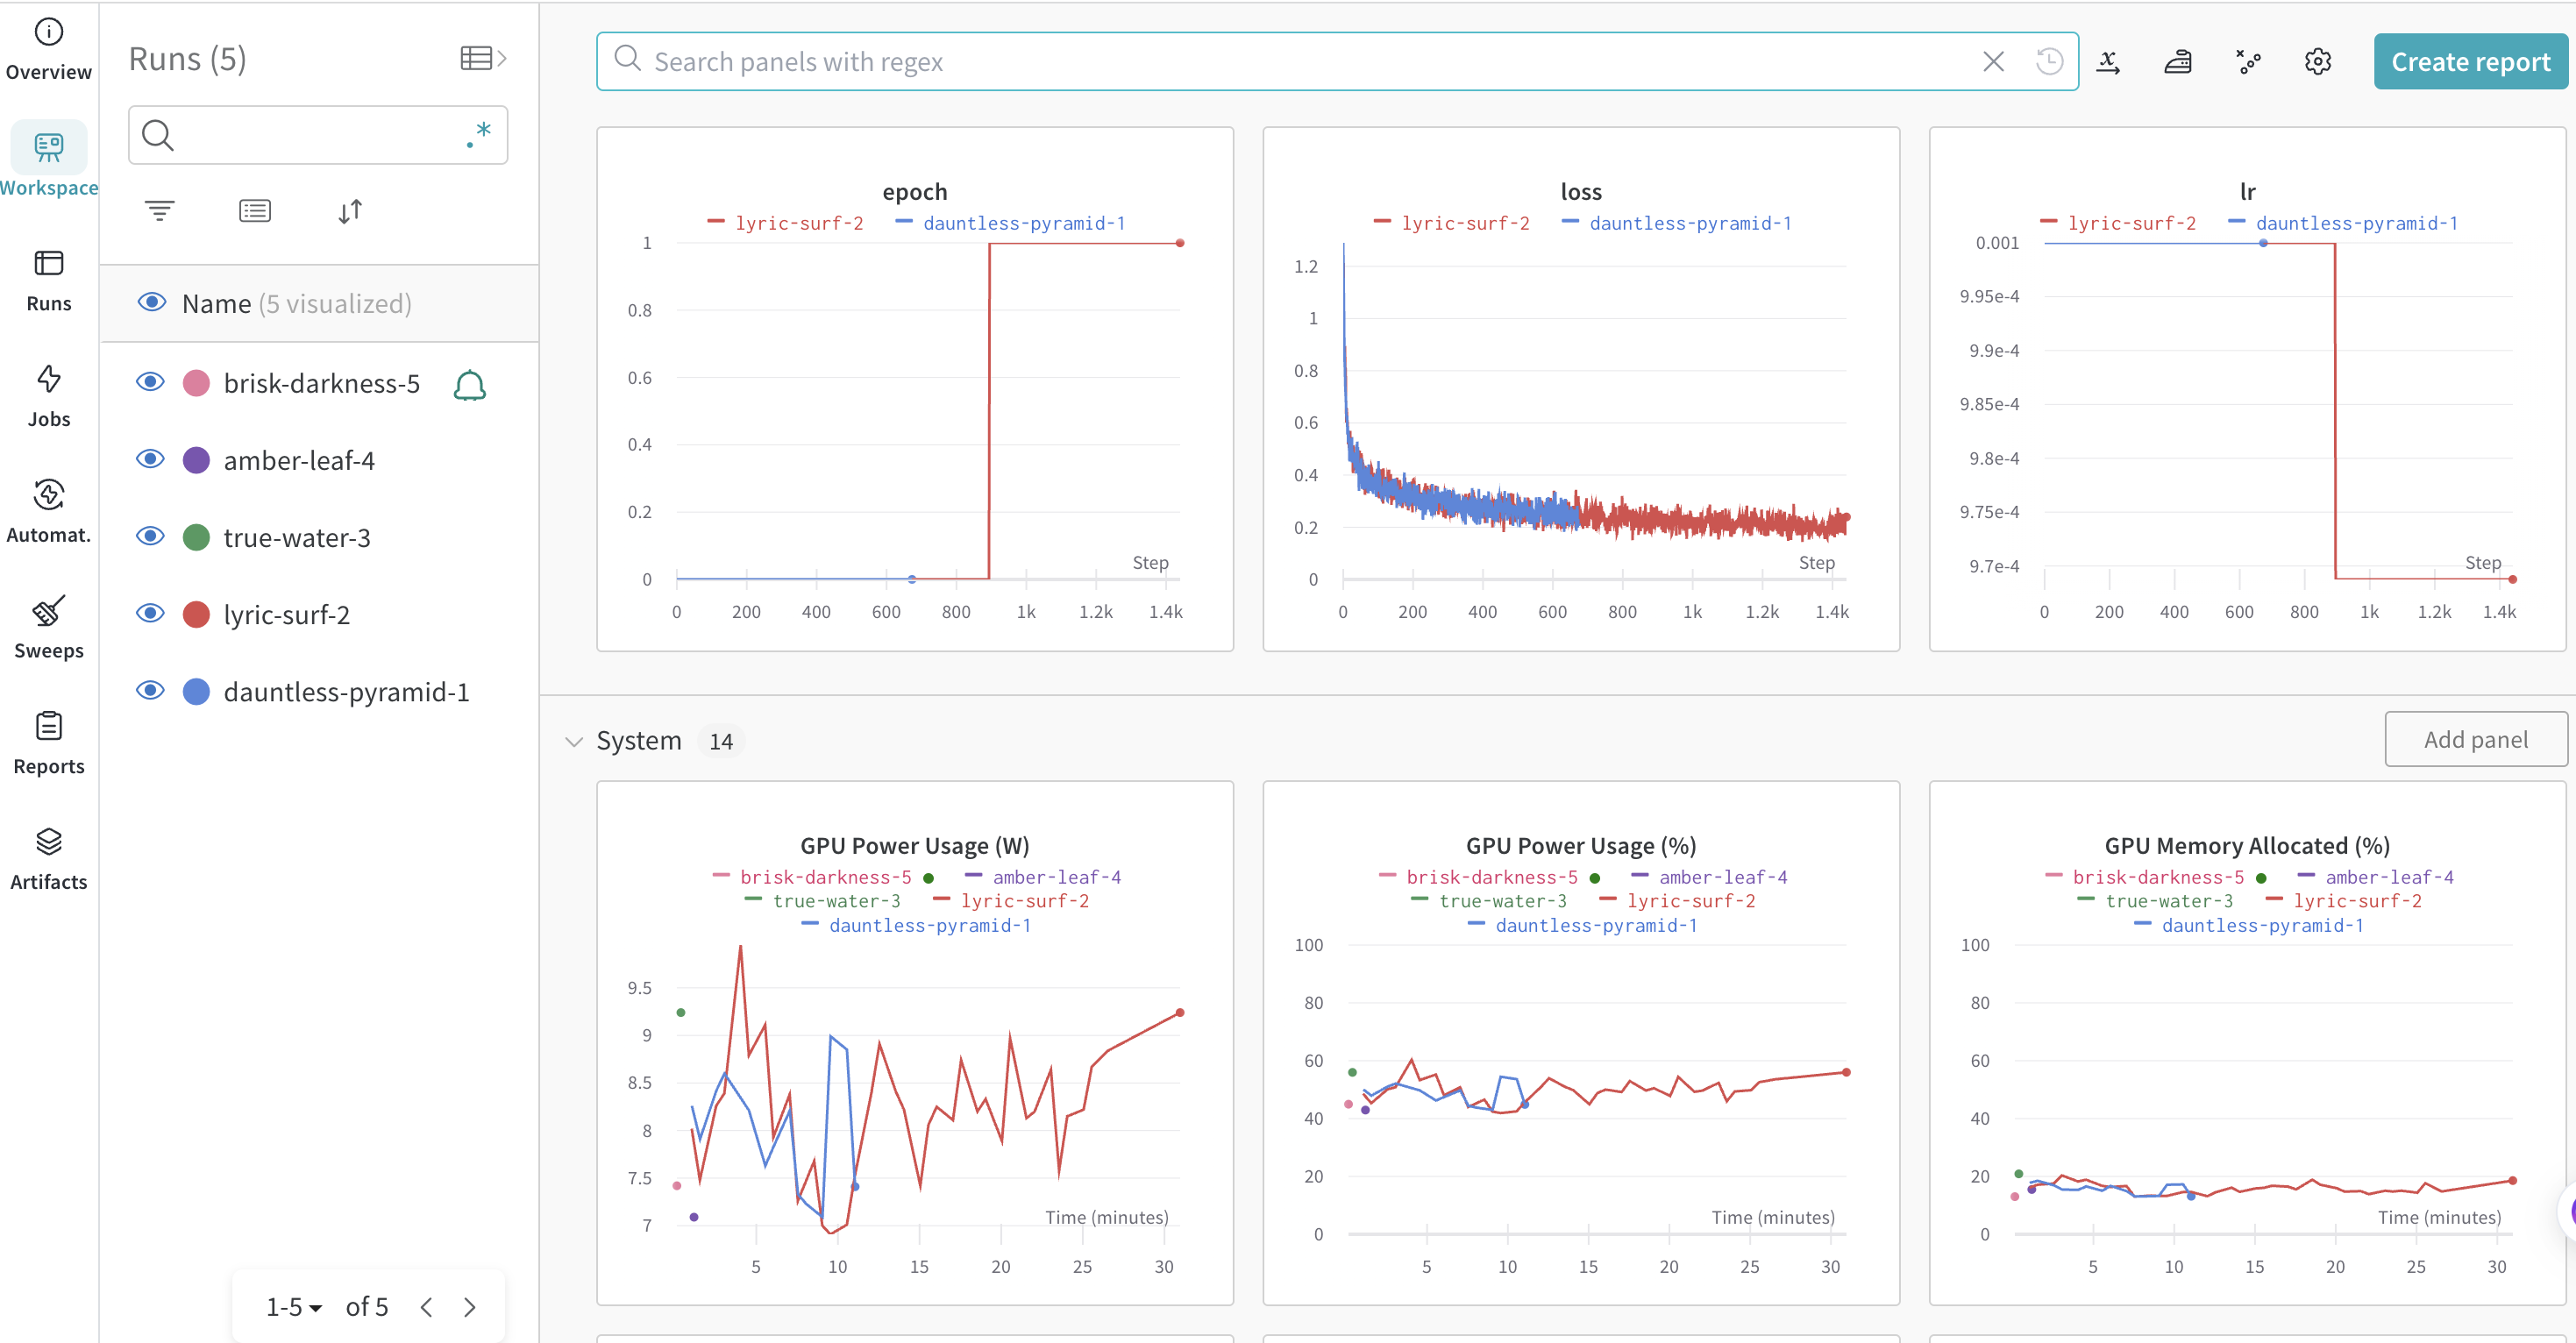
登录wb官网就可以看到训练的可视化信息